# Project of Mobile Robotics 

Students: Farasoa Deborah Rajaona, Yasmine El Goumi, Alexandre de Montleau, François Charroin

# Table of contents
1. [Introduction](#intro)
    * 1.1 [Description of the setup](#setup)
    * 1.2 [Description of the tools used](#tools)


2. [Image Analysis](#img)
    * 2.1 [Detection of obstacles](#obs)
       
        
3. [Global navigation](#nav)
       
4. [Local Navigation](#loc)

5. [Motion control](#mov)

6. [Kalman Filter](#kal)
    * 6.1 [Theory](#kaltheory)
    * 6.2 [Implementation](#kalimplementation)
    * 6.3 [Discussion](#kaldiscussion)
    

7. [Overall Code Implementation](#ov)


8. [Conclusion](#con)
    * [Feedback](#feedback)
    

9. [Appendix]


# 1. Introduction<a name="intro"></a>

As part of our Robotics master at EPFL, we have to program a mobile robot to follow a trajectory. This project consists of 4 different steps: create an environnement, find the best path, control the movements, and avoid obstacles. They require to develop tools: vision, global navigation, local navigation, filtering and motion control.


![alt text](graph.png "Title")

## Description of the setup <a name="setup"></a>

A camera (Aukey pc w1) is placed above the robot and has a view of the entire environnement set for the project. This environnement has been meticulously chosen so that the colors are easely separated by some thresholding functions. The robot (has two pieces of different colored paper (green and red) on its top so that the position and the angle can be deduced. The goal to reach is defined by a blue piece of paper. Obstacles are in black and the ground is white. 

## Description of tools used: <a name="tools"></a>

* __Vision:__
 the camera and some thresholding and filtering. => librairie CV2
* __Global navigation:__
an occupancy grid is created by A* search algorithm
* __Local navigation:__
the proximity sensors of the Thymio are used to detect obstacles.
* __Motion control:__
to reach the goal, two proportionnal controllers are used for the speed of the motors, one to control the orientation of the robot and the other to control its position.
* __Filtering:__
A Kalman filter is used to estimate the position.

The next sections will go in depth about the implementation of these tools.

![alt text](elec.jpg "Title")

In [2]:
#METTRE PHOTO DE THYMIO AVEC BONNE COULEURS SUR LUI

## Discussion<a name="dis"></a>

During the presentation of the project, the details, limitations and goals of this task were established. Because the possibilities of Thymio are great, it was specifically asked to do as simple as possible. Hence a lot of thinking has been done to simplify the implementation without compromising on the robustness of it. 

At this point the project was divided into 4 parts: image analysis, path finding/navigation, motor control, and the Kalman filter.

For the image analysis, the reflexion was really related to the choice of the environnement. To simplify the task, a color was assigned to each type of elements. Tests were done on different colors. Then a choice that has to be done in cooperation with the navigation part was the creation of the map. Thanks to the python library opencv it was possible to dilate obstacles and change the definition of the map.
To conclude the image analysis, by choosing the colors of the elements of the environnement, it only makes the implementation vulnerable the to the light conditions, so by making it constant it makes the image analysis robust.

Navigation is the center of the project, it is linked to all the other parts and the implementation has to be carefully done with respects to each module of the code. Therefore an effort has to be made to make it as simple as possible. For this reason an occupancy grid was chosen over a line based map for the global navigation. After computing the ideal path we only keep points that are at the intersection of a change of direction of the ideal path. These points are called checkpoints. Also we reduce their number using a condition on the distance between two checkpoints. We reduce the number of checkpoints in the aim to keep only the ones that are important for tracking. Thymio will reach each checkpoints, the last one is of course the goal. 
For the local navigation, a threshold is put on the proximity sensors, and then a predetermined motor sequence is used, with continuous rechecks from the sensors.

As the robot is pretty slow there is no point in developing a complex controller, hence a p controller was chosen.

The objective for the filter was to be computationally efficient, therefore the asumptions within the kalman filter make it faster than a particle filter.


## Code <a name="code"></a>

The first thing to do is to import the libraries that will be used during the whole project.

In [3]:
import cv2
import time
import matplotlib.pyplot as plt
import numpy as np

%matplotlib notebook 
import matplotlib.pyplot as plt
%matplotlib notebook

from bokeh.plotting import figure
from bokeh.io import output_notebook, show, push_notebook
from tqdm import tqdm

import IPython.display as Disp
from ipywidgets import widgets

### 1. Image Analysis <a name="img"></a>

The camera that captures the environnement from above is used for multiple puposes. At the begining, a picture is taken so that the details of the environnement can be known: localisation of obstacles, thymio robot, and the arrival that has to be reached. During the shifting of the robot the camera has a crucial role in determining the position and the angle of the mobile robot.

- __Input__: a video 

- __Outputs__: Masks that separate the elements, the overall map, the localisation of the thymio and the arrival.

The picture below (created on paint) is the one with which the initial tests were done. It was a good way to tune the conditions for the masks.

In [ ]:
#mettre photo capture d'ecran et celle obstacles localisés cote à cote

![alt text](testcolor3.jpg "Title")

A crucial point for the image analysis is the choice of the colors, as previously written the four chosen are black, green, red and blue, because they are easy separates from one to another. 

Most of the images are converted to HSV, because it is less sensible to lightening conditions of the room.

<a name="obs"></a>The first step during the image analysis is to determine where the obstacles are. They all have the same color:black. Therefore it's pretty simple to seperate them from the rest by using a filter and then creating a mask. The second part of this step is to dilate the obstacles in the mask thanks to the function cv2.dilate used in the second exercises session. The dilatation of the obstacles is done so that the size of the thymio can be ignored during the pathfinding step.

__The variables are:__

- __lower dark and higher dark__: the lower and higher limits in hsv to detect black
- __fin__: the map of the obstacles only

We use the Aukey camera connected to the laptop by calling VideoCapture(0).

In [ ]:
capture = cv2.VideoCapture(0) 
while True:
    ret, frame = capture.read()
    cv2.imshow('video', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        cv2.imwrite('capture.jpg', frame)
        break
capture.release()
cv2.destroyAllWindows()

A Gaussian Blur is used to remove the noise and make it easier to apply the black mask on the image.

In [ ]:
out=cv2.imread('capture.jpg')

# Mask for black obstacles 
lower_dark = np.array([0,0,0])
higher_dark = np.array([40,40,40])
mask=cv2.inRange(out,lower_dark,higher_dark)
mask=cv2.GaussianBlur(mask,(5,55),0)
ret, mask = cv2.threshold(mask, 200, 255, cv2.THRESH_BINARY)

result=cv2.bitwise_and(out,out,mask=mask)
kernel = np.ones((50,50),np.uint8)
fin = cv2.dilate(mask, kernel, iterations = 3)
fig = plt.figure(figsize=(20, 14))
columns=3
fig.add_subplot(1, columns, 1)
plt.imshow(cv2.cvtColor(out, cv2.COLOR_BGR2RGB)) 
fig.add_subplot(1, columns, 2)

plt.imshow(fin)


<a name="thy"></a>The next step is to create a mask for each of the other colors: blue, green and red. For these mask the image is converted to HSV but the principle is the same as previously. Here there is no dilation as only the localisation of these colors is wanted.

First we'll have to use a function that converts pixels to cms so we can scale the goal and start accordingly and ease the calculations. To do so we take the measurement between the two colors on top of the Thymio, knowing it measures 5cm.

In [ ]:
#conversion pixels en cm
def pix_to_cm(point_rouge1, point_rouge2, point):
    
    norme_rouge = np.sqrt((point_rouge2[0] - point_rouge1[0])**2 + (point_rouge2[1]- point_rouge1[1])**2)
    point = np.array(point)*(5/norme_rouge)
    
    return point

We initialize the masks for our different colours.

__The variables are__:
- __lower1 and upper1 or lower2 and upper2__: the lower and higher boundaries for the red colour in HSV
- __low_green and high_green__: the lower and higher boundaries for the green colour in HSV
- __low_blue and high_blue__: the lower and higher boundaries for the blue colour in HSV

In [ ]:
# Initialisation
low_green = np.array([40, 55, 70]) 
high_green = np.array([102, 255, 255]) 

low_blue = np.array([96, 100, 50])
high_blue = np.array([126, 255, 255])

point_rouge10= np.zeros(2,) # Point rouge sur le Thymio
point_rouge20 = np.zeros(2,) # Point vert sur le Thymio

# lower boundary RED color range values; Hue (0 - 10)
lower1 = np.array([0, 100, 20])
upper1 = np.array([10, 255, 255])
 
# upper boundary RED color range values; Hue (160 - 180)
lower2 = np.array([160,100,20])
upper2 = np.array([179,255,255])


Because these colors represent the thymio and the arrival, the localisation of these need to be known, hence their centroids are calculated in a similar way as it is done in the correction of the second exercise session in the _for c in contours_ loops.<a name="cen"></a>

The first loop is done to find the Thymio position via the red point, the second one via the green point, and the third loop is used to find the blue goal.

In [ ]:
cap = cv2.VideoCapture(0)

In [ ]:
while True:
    _, frame = cap.read()
    #frame = cv2.GaussianBlur(frame,(5,35),0)
    hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
#1. Trouver la position du thymio, point ROUGE
    #track_red:
    
    lower_mask = cv2.inRange(hsv_frame, lower1, upper1)
    upper_mask = cv2.inRange(hsv_frame, lower2, upper2)
    red_mask = lower_mask + upper_mask;
    red = cv2.bitwise_and(frame, frame, mask=red_mask)
    contours, hierarchy = cv2.findContours(red_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    point_rouge10 = np.zeros(2,)

    
    for c in contours:
        
        area = cv2.contourArea(c)
        if area > 300:
            cv2.drawContours(frame,[c],-1,(0,0,255), 3)
            M = cv2.moments(c)
            cx_red = int(M["m10"]/ M["m00"])
            cy_red = int(M["m01"]/ M["m00"])
            cv2.circle(frame,(cx_red,cy_red),7,(255,255,255),-1)
            
            
            point_rouge10 =  [cx_red, cy_red]
            cv2.putText(frame, str(cx_red), (cx_red-20,cy_red-20), 1,1, (255,255,255))
            cv2.putText(frame, str(cy_red), (cx_red+20,cy_red-20), 1,1, (255,255,255))
            
                
    cv2.imshow("result",frame)

#1. Trouver la position du thymio, point VERT
    #track green:

    green_mask = cv2.inRange(hsv_frame, low_green, high_green)
    #green_mask = cv2.GaussianBlur(green_mask,(21,21),0)
    green = cv2.bitwise_and(frame, frame, mask=green_mask)
    
    contours, hierarchy = cv2.findContours(green_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    for c in contours:
        
        area = cv2.contourArea(c)
        if area > 300:
            cv2.drawContours(frame,[c],-1,(0,0,255), 3)
            M = cv2.moments(c)
            cx_green = int(M["m10"]/ M["m00"])
            cy_green = int(M["m01"]/ M["m00"])
            cv2.circle(frame,(cx_green,cy_green),7,(255,255,255),-1)
            
            point_rouge20 =  [cx_green, cy_green]
            cv2.putText(frame, str(cx_green), (cx_green-20,cy_green-20), 1,1, (255,255,255))
            cv2.putText(frame, str(cy_green), (cx_green+20,cy_green-20), 1,1, (255,255,255))
              
#2. Trouver le goal 
    # Track blue:
    
    blue_mask = cv2.inRange(hsv_frame, low_blue, high_blue)
    blue = cv2.bitwise_and(frame, frame, mask=blue_mask)
    
    contours, hierarchy = cv2.findContours(blue_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    for c in contours:
        
        area = cv2.contourArea(c)
        if area > 300:
            cv2.drawContours(frame,[c],-1,(255,0,0), 3)
            M = cv2.moments(c)
            cxb = int(M["m10"]/ M["m00"])
            cyb = int(M["m01"]/ M["m00"])
            cv2.circle(frame,(cxb,cyb),7,(255,255,255),-1)
                
            cv2.imshow("result",frame)
        
            goal_pix = [cxb, cyb]
        
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        print('Goal position:', goal_pix)
        break
    

There are two different colors on Thymio, green in the front and red in the back so that the angle for every orientiations can be calculated. The position of Thymio corresponds to the average of these two colors.

In [ ]:
#calcul de la position initiale du Thymio
start_pix = [round((point_rouge20[0] + point_rouge10[0])/2), round((point_rouge20[1] + point_rouge10[1])/2)]
print("Start in pixels:", start_pix)

At the beginning of the path finding the mask of the obstacles is resized so that it is less computationally demanding, therefore the localisations calculated with the centroïds need to be rescaled. The function round is used in order to have an integer.

In [ ]:
#rescale les coordonnées:
xgoal = round(goal_pix[0]/30)
ygoal = round(goal_pix[1]/30)

xstart = round(start_pix[0]/30)
ystart = round(start_pix[1]/30)

goal = (ygoal,xgoal)
goal_array_test = [xgoal, ygoal]
goal_array2 = [xgoal, ygoal]

start = (ystart,xstart)

print(frame.shape) #montre y en premier

Here are pros and cons about the tools implemented for the image analysis:

__Pros__:
- Good overall accuracy
- Outliers are removed with the filtering

__Cons__:
- Dependant on the light condition of the room

## 2. Navigation <a name="nav"></a>

The navigation is composed of two states: global and local navigation. This section will explore the two and the conditions that allow one navigation to take over the other.

### Global Navigation:<a name="glo"></a>

The global navigation is the primary type of navigation, and the one that should be used the most. It is a pathfinder that is called at the beginning. The path is determined by the map of the obstacles and the localisation of the thymio and the arrival.

__Input__: a map which is the mask of obstacles, the localisation of the thymio and the arrival

__Output__: the path to follow

![alt text](map1.png "Title")

Here is an example of a map created by the steps descibed in the image analysis part, the dilated obstacles are in yellow. The first step is to resize to a 64 by 36 image. The goal is to make an occupancy grid where one pixel correspond to one box of the grid. Resizing allows to have an occupancy grid with 9000 times less boxes, helping the pathfinding to be less computationnaly demanding. 

The global navigation of the robot uses an occupancy grid where one pixel represents one box of the grid. The path finding is done thanks to an A* algorithm with all possible 8-connectivity movements similary to the exercise session 5, here the occupancy grid is not a square but a rectangle.

The functions implemented are: 

- __create_empty_plot__: it is a helper function to create a figure of the desired dimensions & grid, we want a figure of 36x64
- __get_movements__: get all the connectivity movements (4 or 8)
- __reconstruct_path__: recurrently reconstructs the path from start node to the current node
- __A_star__: A* for 2D occupancy grid. Finds a path from start to goal. h is the heuristic function. h(n) estimates the cost to reach goal from node n.

In [ ]:
dim = (64,36) #(64,36)

mask_noir = cv2.resize(fin, dim, interpolation = cv2.INTER_AREA)
max_valx = 36
max_valy = 64

data = np.array(mask_noir) #hough_maxima

limit = 250
occupancy_grid = data.copy()
occupancy_grid[data>limit] = 1
occupancy_grid[data<=limit] = 0

In [ ]:
def create_empty_plot(max_valx, max_valy):
    fig, ax = plt.subplots(figsize=(7,7))
    
    major_ticksx = np.arange(0, max_valx+1, 5)
    minor_ticksx = np.arange(0, max_valx+1, 1)
    
    major_ticksy = np.arange(0, max_valy+1, 5)
    minor_ticksy = np.arange(0, max_valy+1, 1)
    
    ax.set_xticks(major_ticksx)
    ax.set_xticks(minor_ticksx, minor=True)
    ax.set_yticks(major_ticksy)
    ax.set_yticks(minor_ticksy, minor=True)
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    ax.set_ylim([-1,max_valy])
    ax.set_xlim([-1,max_valx])
    ax.grid(True)
    
    return fig, ax

In [ ]:
def _get_movements_4n():
    return [(1, 0, 1.0),
            (0, 1, 1.0),
            (-1, 0, 1.0),
            (0, -1, 1.0)]

def _get_movements_8n():
    s2 = math.sqrt(2)
    return [(1, 0, 1.0),
            (0, 1, 1.0),
            (-1, 0, 1.0),
            (0, -1, 1.0),
            (1, 1, s2),
            (-1, 1, s2),
            (-1, -1, s2),
            (1, -1, s2)]

In [ ]:
def reconstruct_path(cameFrom, current):
    total_path = [current]
    while current in cameFrom.keys():#COOOL
        #Add where the current node came from to the start of the list
        total_path.insert(0, cameFrom[current]) #j'assigne à la position 0 à chaque fois.
        current=cameFrom[current]
    return total_path


def A_Star(start, goal, h, coords, hough_maxima, movement_type="8N", max_valy = max_valy):
    
    # Check if the start and goal are within the boundaries of the map
    for point in [start, goal]:
        for coord in point:
            assert coord>=0 and coord<max_valy, "start or end goal not contained in the map"
    
    # check if start and goal nodes correspond to free spaces
    if occupancy_grid[start[0], start[1]]:
        raise Exception('Start node is not traversable')

    if occupancy_grid[goal[0], goal[1]]: #je pense = 1 si  obstacle
        raise Exception('Goal node is not traversable')
    
    # get the possible movements corresponding to the selected connectivity
    if movement_type == '4N':
        movements = _get_movements_4n()
    elif movement_type == '8N':
        movements = _get_movements_8n()
    else:
        raise ValueError('Unknown movement')
    
    
    # Here we initialise the variables
    
    # The set of visited nodes that need to be (re-)expanded, i.e. for which the neighbors need to be explored
    # Initially, only the start node is known.
    openSet = [start]
    
    # The set of visited nodes that no longer need to be expanded.
    closedSet = []

    # For node n, cameFrom[n] is the node immediately preceding it on the cheapest path from start to n currently known.
    cameFrom = dict() #camefrom le (x,y) sur le chemin optimal juste avant le node n = (currentx, currenty)

    # For node n, gScore[n] is the cost of the cheapest path from start to n currently known.
    gScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    gScore[start] = 0

    # For node n, fScore[n] := gScore[n] + h(n). map with default value of Infinity
    fScore = dict(zip(coords, [np.inf for x in range(len(coords))])) #il donne la valeur infini à chaque coordonnées
    fScore[start] = h[start] #ce h il vaut combien => on l'a calculé au départ
#range creer tableau de longueur len(coords)
    
    # while there are still nodes to visit

    while openSet != []:
        
            
        min = np.inf
        for p in openSet:
            if fScore[p] < min: #ici je vais reach for celui qui a le plus petit fScore et donc hScore
                min = fScore[p] 
                current = p
                
        #np.delete(openSet, current)
        #np.append(ClosedSet, current)
        
        openSet.remove(current)
        closedSet.append(current)
    
        #If the goal is reached, reconstruct and return the obtained path
        
        if current == goal: #ecriture vectorisé
            return reconstruct_path(cameFrom,current), closedSet

        # If the goal was not reached, for each neighbor of current:
        for dx, dy, deltacost in movements:
            
            neighbor = (current[0]+dx, current[1]+dy)
            
            # if the node is not in the map, skip
            if (neighbor[0] >= occupancy_grid.shape[0]) or (neighbor[1] >= occupancy_grid.shape[1]) or (neighbor[0] <0) or (neighbor[1] <0):
                continue
            
            # if the node is occupied or has already been visited, skip
            if (occupancy_grid[neighbor[0],neighbor[1]] == 1) or (neighbor in closedSet):
                continue
                
            # compute the cost to reach the node through the given path
            
            tentative_gScore = gScore[current] + deltacost
            
            # Add the neighbor list of nodes who's neighbors need to be visited
            if neighbor not in openSet:
                openSet.append(neighbor)
            
            
            # If the computed cost if the best one for that node, then update the costs and 
            # node from which it came
            if tentative_gScore < gScore[neighbor]: #gScore[neighbor] a une valeur infinie
 
                # This path to neighbor is better than any previous one. Record it!
                cameFrom[neighbor] = current #j'ai l'impression que tout les neighbors de current seront dans camfrom hors on veut ceux qui on la plus faible f value
                gScore[neighbor] = tentative_gScore 
                fScore[neighbor] = gScore[neighbor] + h[neighbor]  #ici je compute le fscore pour tout les neighbors et plus loin je vais chercher le fscore plus petit qui va devenir current
                
                

    # Open set is empty but goal was never reached
    print("No path found to goal")
    return [], closedSet                                                  

Having a path constructed with an occupancy grid can lead to movement that is not smooth if there is a lot of direction changes. Each time the trajectory change in direction, a checkpoint is created.

In [ ]:
# List of all coordinates in the grid
x,y = np.mgrid[0:occupancy_grid.shape[0]:1, 0:occupancy_grid.shape[1]:1] 
#x,y = np.mgrid[0:max_val:1, 0:max_val:1]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
pos = np.reshape(pos, (x.shape[0]*x.shape[1], 2))
coords = list([(int(x[0]), int(x[1])) for x in pos])

# Define the heuristic, here = distance to goal ignoring obstacles
h = np.linalg.norm(pos - goal, axis=-1) 
h = dict(zip(coords, h)) # cool

# Run the A* algorithm
path, visitedNodes = A_Star(start, goal, h, coords, occupancy_grid, movement_type="8N")

checkpoint = []
direction = []
for x in range(1,len(path)):
    v = np.array(path[x]) - np.array(path[x-1])
    direction.append(v)

for x in range(1,len(path)-1):
    if ((direction[x-1][0] != direction[x][0]) | (direction[x-1][1] != direction[x][1])):
               checkpoint.append(path[x])

checkpoint.append(goal)
            
checkpoint_2 = np.array(checkpoint).reshape(-1, 2).transpose()

path = np.array(path).reshape(-1, 2).transpose()
visitedNodes = np.array(visitedNodes).reshape(-1, 2).transpose()

In [ ]:
# Displaying the map
fig_astar, ax_astar = create_empty_plot(36, 64)

ax_astar.imshow(occupancy_grid.transpose(), origin='upper')
ax_astar.scatter(visitedNodes[0], visitedNodes[1], marker="o", color = 'orange');
ax_astar.plot(path[0], path[1], marker="o", color = 'blue');
ax_astar.plot(checkpoint_2[0], checkpoint_2[1], marker="o", color = 'black');
ax_astar.scatter(start[0], start[1], marker="o", color = 'red', s=200);
ax_astar.scatter(goal[0], goal[1], marker="o", color = 'blue', s=200);

To reduce the number of checkpoints a minimum distance between them is set so that the trajectory can be mostly straight.

In [ ]:
# Smooth the checkpoints
upsized_checkpoint =  [i * 30 for i in checkpoint_2]
checkpoint_cm = pix_to_cm(point_rouge10, point_rouge20,upsized_checkpoint)

x = checkpoint_cm[0]
y = checkpoint_cm[1]

new_checkpoint_2_x = checkpoint_2[0]
new_checkpoint_2_y = checkpoint_2[0]



var = []

for j in range(0, len(checkpoint_cm[0])-2):
    dist_current = np.sqrt((checkpoint_cm[0][j+1] - checkpoint_cm[0][j])**2 + (checkpoint_cm[1][j+1] - checkpoint_cm[1][j])**2)
    if dist_current < 5:
        var.append(j+1)   
                

new_checkpoint_x_cm = np.delete(x, var)
new_checkpoint_y_cm = np.delete(y, var)

new_checkpoint_x = np.delete(upsized_checkpoint[0], var)
new_checkpoint_y = np.delete(upsized_checkpoint[1], var)

new_checkpoint_2_x=np.delete(checkpoint_2[0], var)
new_checkpoint_2_y=np.delete(checkpoint_2[1], var)

print(checkpoint_2[0])
print(new_checkpoint_2_x)

In [ ]:
# Displaying the map
fig_astar, ax_astar = create_empty_plot(36, 64)

ax_astar.imshow(occupancy_grid.transpose(), origin='upper')
ax_astar.scatter(visitedNodes[0], visitedNodes[1], marker="o", color = 'orange');
ax_astar.plot(path[0], path[1], marker="o", color = 'blue');
ax_astar.plot(new_checkpoint_2_x, new_checkpoint_2_y, marker="o", color = 'black');
ax_astar.scatter(start[0], start[1], marker="o", color = 'red', s=200);
ax_astar.scatter(goal[0], goal[1], marker="o", color = 'blue', s=200);

Here are pros and cons about the tools implemented for the global navigation:

__Pros__:
- Easy implementation
- Computationnaly efficient

__Cons__:
- Only 8 directions possible

In [1]:
#rajouter image du de la grille avec checkpoints puis celle avec nb checkpoints reduits

### Local Navigation:<a name="loc"></a>

The goal of the local navigation is to avoid objects that will be placed after the creation of the map and the global navigation. It can also help to avoid objects that were not detected in the first place by the mask during the image analysis.

__Inputs__: proximity sensors values

__Outputs__: motors values

The local navigation is done thanks to the proximity sensors. We use three of them so that obstacles on the front and on the sides can be detected. 

1. Obstacle is detected.
2. Thymio will go backwards
3. It will turn a 90 degree angle to the left or right, depending on the values of the sensor.
4. It will go straight for a few seconds.
5. Go back to global navigation.

The variable named "state" correspond to the nature of navigation: local or global. If the state is at 0 it is set to global navigation, if it is at 1 it is in obstacle avoidance.

The conditions of the switches between the two and the local navigation are shown below. "obstThrH" represent the theshold for the proximity sensors.

__The variables used are:__
- __speed0__: it is the nominal speed during obstacle avoidance
- __speedGain__: it is the speed proportional factor for the wheels
- __obstThrL and obstThrH__: it is the low and high obstacke threshold to switch states
- __obstSpeedGain__: it is the gain when turning the wheels
- __Ul, Ur__: the speeds sent to the motor when switches are made
- __tourne_g__: it's a state that defines whether the robot should turn left or not, depends on whether the obstacle is detected on the left or right of the robot.


__*The local navigation code can be observed in the Overall implementation code.*__

Here are pros and cons about the tools implemented for the local navigation:
    
__Pros__:
- Synergises well with the global navigation
    
__Cons__:
- Will not always lead to the best path


## 3. Movement: global motion control<a name="mov"></a>

A Proportional controller is implemented.

__The variables used are__:
- __Ul, Ur__: the speeds that are sent to the motors
- __Xr, Yr, theta_r__: the robot positions in real time
- __The function "motors"__: sends the values to the robot
- __Xt, Yt__: the target positions (the checkpoints and then the goal).

The functions returns Ul, Ur and the errors.

In [ ]:
def controller(Xr, Yr, theta_r, Xt, Yt):
    Ul = 0
    Ur = 0
    marge_s= 40
    marge_t = 5   
    
    delta_Xref = Xt - Xr
    delta_Yref = Yt - Yr
    if delta_Xref != 0:
        phi = round( np.rad2deg(np.arctan2(delta_Yref, delta_Xref)))
        delta_phi = -(phi - theta_r)
        #if phi >=0 and theta_r>=0:
        #    delta_phi = -(phi + theta_r)
        #if phi >=0 and theta_r<=0:
        #    delta_phi = -(phi - theta_r)
        
        if phi <=0 and theta_r>0:
            delta_phi = delta_phi
        
        
    if delta_Xref == 0:
        delta_phi = 90 - theta_r
        phi = 90
    
    
    Ks = 0.3 #1/(R*h)
    #Ks = 0
    Kt = 1.7 #/(R*h)
    
    #Angular error
    Et = round(delta_phi)
    
    if abs(Et)< marge_t:
        Et = 0
        #Ks = 1
        
        
    # Position error
    Es = round(np.sqrt(delta_Xref**2 + delta_Yref**2 ) + np.cos(delta_phi))
    
    if abs(Es)< marge_s:
        Es = 0
        Et = 0
    
   
    
    #Proportional controller 
    Vs = Ks*Es
    Vt = Kt*Et
    
    
    Ul = 90+round(Vs - Vt) #delta_phi / Et < 0 => Vt<0: on tourne à droite 
    Ur = 90+round(Vs + Vt)
    
    if Ul > 350:
        Ul = 350
        
    if Ur > 350:
        Ur = 350
        
    if Ul < -350:
        Ul = -350
    
    if Ur < -350:
        Ur = -350
    
    return Ul, Ur, Es, Et, phi, Vs, Vt  

In [ ]:
def motors(left, right):
    return {
        "motor.left.target": [left],
        "motor.right.target": [right],
    }

Here are pros and cons about the tools implemented for the P controller:

__Pros__:
- Easy to work with
- The speed of the robot makes it useless to use a more complex controller

__Cons__:
- Not the smoothest movement, some sudden moves may happen (that can actually impact the Kalman filter prediction)

## 4. Kalman Filter<a name="kal"></a>

## Theory<a name="kaltheory"></a>

A Kalman filter is a sensor-fusion tool that is used to best approximate the robot's position in real time. In this case, the two sensors used are the positions in real time, coming from the camera, and the speed of the wheels, considered as inputs. The filter will help us localize the robot anytime, even if at some point, the camera is hidden, because the speed of the wheels is always known. It works as such:

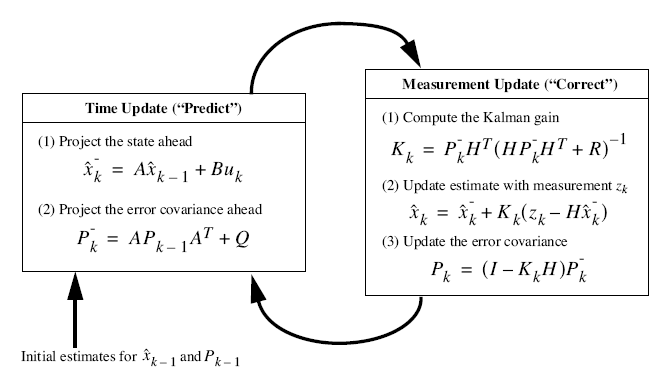

The kinematic equations of a differential-drive robot are given, allowing us to define the A and B matrices.

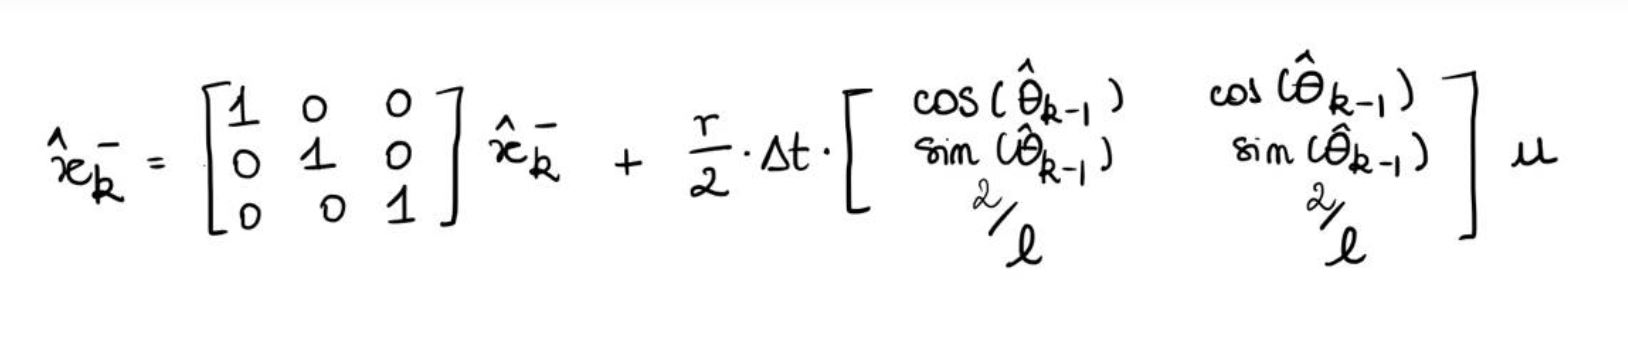

## Implementation <a name="kalimplementation"></a>

The variables used are:
- __State_est_t, P_est_t__ : State_est_t it is the previous state during the prediction state, its composants are [x position, y position, angle], and P_est_t is the covariance matrix that we initialize as a diagonal matrix with 1000, but it will be updated later
- __A__ is the identity matrix in our case
- __B__: it has been computed following the kinematic equations of a differential-drive robot
- __u__: the input vector, containing the speeds of the two wheels
- __H__: the identity matrix because we observe our 3 states during the update step
- __State_t, P_t__: the state and covariance matrix after the update step
- __K__: the Kalman gain
- __Q_t and R_t__: noise covariances matrices. For simplicity reasons, they have been chosen thanks to the 8th exercise session of the course.
- __Z_t__: the measurements coming from the camera sensor
- __temps_ecoule__: the time it takes to compute one while loop, it has been calculated and found that it takes 0.01s
- __r__: the radius of the Thymio wheels
- __l__: the length between the Thymio wheels

During the update step there are two cases that can happen, and depend on __MaskAvailable__: 

- when MaskAvailable is True, that means the camera sensor is available and we receive the Z_t measurements, so the updates are computed. 
- if MaskAvailable is not available, then we are stuck in the prediction step and the Kalman gain is set to 0 to do that.

In the program it is calculated as follows:

__Note__: The angle has to be converted to degrees as its output will be as radians.

In [ ]:
def prediction(State_est_t_1,P_t_1,Q_t,left_speed,right_speed, temps_ecoule):
    k_v = 1
    k_d= 1
    r=2*k_d
    l=9.5*k_d
    State_est_t=State_est_t_1
    State_est_t_1[2]=np.deg2rad(State_est_t_1[2])
    
    
    A = np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
    
    B= np.array([[(r/2)*temps_ecoule*np.cos(State_est_t_1[2]),(r/2)*temps_ecoule*np.cos(State_est_t_1[2])], 
                 [(r/2)*temps_ecoule*np.sin(State_est_t_1[2]),(r/2)*temps_ecoule*np.sin(State_est_t_1[2])], 
                 [r*temps_ecoule/l, r*temps_ecoule/(-l)]])
    
    u=[left_speed*k_v, right_speed*k_v]
    
    State_est_t=np.dot(A,State_est_t_1)+np.dot(B,u)    
    P_t_1 = np.dot(np.dot(A,P_t_1),A.T) + Q_t
    
    State_est_t[2]=np.rad2deg(State_est_t[2])

    return State_est_t,P_t_1

When this is done, what follows is the update of the parameters.

In [ ]:
def update(State_est_t,P_t,Z_t,R_t, MaskAvailable, points, angle):
    H=np.array([[1, 0, 0], [0, 1, 0], [0, 0, 1]]) #matrice d'observation
    
    S = np.dot(np.dot(H,P_t),H.T) + R_t
    
    if MaskAvailable:
        K = np.dot(np.dot(P_t,H.T),np.linalg.inv(S))
    else:
        K=0
    
    y = Z_t - np.dot(H,State_est_t)
   
    State_t = State_est_t + np.dot(K,y)
    
    I = np.eye(3)
    P_t = np.dot((I - np.dot(K,H)),P_t)
        
    return State_t,P_t

## Discussion <a name="kaldiscussion"></a>

The Kalman filter works perfectly as hoped when both sensors are used: there is a small error during the predicting step, that is corrected by the innovation/residual for the update step.

However, when the camera is hidden, if an error starts appearing, it will not be corrected and will keep getting bigger and lead our robot the wrong way. That is why working with sensor-fusion with both sensors is the best way to know the robot's position. Since the setup and recognition of the robot relies heavily on the lightning of the room, the way the camera is hidden also heavily affects the filter: if the object hiding the camera is colourful, it could be mistaken as a red or green point and lead the algorithm to believe that that's where the robot is actually located. 

## 5. Overall Code Implementation<a name="ov"></a>

Now that we have the map, the goal, obstacles, start, we can start to navigate the Thymio. First, we initialize the variables for the functions stated above so as to not get errors.

First the controller variables:

In [ ]:
Ul= 0 
Ur= 0
Es= 0 
Et=0
phi=0
marge_s = 40
marge_t = 5
current = 0
Xt = new_checkpoint_y
Yt = new_checkpoint_x

For the Kalman filter: 

In [ ]:
State_est_t=[0, 0, 0] 
Q_t = np.diag([0.0004, 0.0615, 0.0004])
R_t=np.diag([0.0025, 0.0615, 0])
angle_deg=0
points=[[0], [0], [0]]
P_t = np.diag([1000.0, 1000.0, 1000.0])
speedconv=0.0435
temps_ecoule=0.01
Z_t=[0,0,0]
j=0
State_t=[0,0,0]
P_t=np.diag([1000,1000,1000])
prev_state = [[0,0,0] for i in range(0, 50)]

For the local navigation:

In [ ]:
speedGain = 2      # gain used with ground gradient
obstThrH = 20      # high obstacle threshold to switch state 0->1
obstSpeedGain = 10  # /100 (actual gain: 5/100=0.05)
state = 0        # 0=follow the trajectory, 1=obstacle avoidance
obst = [0,0]       # measurements from left and right prox sensors
tourne_g = 0
prox_horizontal = [0,0,0,0,0,0,0]

Now we will start working in an infinite while loop that can be stopped if the user presses on the __'q'__ button while on the Python tab. 

The new variables introduced in this program are: 
- __prev_state__: it is an array that will store all the position values and will be very efficient for the Kalman filter. We had noticed that when the camera was hidden, the coordinates that were sent didn't change during the whole time it was hidden, so we use this array to see if the Thymio positions are the same for a certain time, then we are in the __MaskAvailable=False__ condition.

The steps followed by the algorithm are:
1. Track the Thymio in real time: find its (x,y) coordinates, and its angle
2. We send the positions to the Kalman filter as the __Z_t__ measurements to help with the update step.
3. The updated estimations are sent to the controller: these estimations will be correct when the camera is available, if it is not, the controller will use the prediction estimations to keep navigating.
4. The proximity values are taken every 0.01s, so as to not miss if an obstacle is put on the way.
5. If an obstacle is detected, go into obstacle avoidance mode. Once it is not detected anymore, it goes back to global navigation.

In [ ]:
capt = cv2.VideoCapture(0) 

In [ ]:
# Motion of the Thymio

while True:
    _, frame = capt.read()
    hsv_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    
    # Dislay the goal 
    cv2.circle(frame,(goal_pix[0],goal_pix[1]),7,(255,255,255),-1)
    
    # Display the checkpoints:
    for i in range(len(new_checkpoint_x)):
        cv2.circle(frame,(new_checkpoint_y[i],new_checkpoint_x[i]),5,(0,255,255),-1)
        
    
#1. Position in real time of the Thymio
    # Track red dot
    lower_mask = cv2.inRange(hsv_frame, lower1, upper1)
    upper_mask = cv2.inRange(hsv_frame, lower2, upper2)
    red_mask = lower_mask + upper_mask;
    red = cv2.bitwise_and(result, result, mask=red_mask)
    contours, hierarchy = cv2.findContours(red_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    for c in contours:
        area = cv2.contourArea(c)
        if area > 300:
            cv2.drawContours(frame,[c],-1,(0,0,255), 3)
            M = cv2.moments(c)
            cx_red_rt = int(M["m10"]/ M["m00"])
            cy_red_rt = int(M["m01"]/ M["m00"])
            cv2.circle(frame,(cx_red_rt,cy_red_rt),7,(0,0,255),-1)
            pt_thymio_red_rt =  [cx_red_rt, cy_red_rt]
    
    # Track green dot:
    green_mask = cv2.inRange(hsv_frame, low_green, high_green)
    green = cv2.bitwise_and(frame, frame, mask=green_mask)
    contours, hierarchy = cv2.findContours(green_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    for c in contours:
        area = cv2.contourArea(c)
        if area > 300:
            cv2.drawContours(frame,[c],-1,(0,0,255), 3)
            M = cv2.moments(c)
            cx_green_rt = int(M["m10"]/ M["m00"])
            cy_green_rt = int(M["m01"]/ M["m00"])
            cv2.circle(frame,(cx_green_rt,cy_green_rt),7,(0,255,0),-1)
            pt_thymio_green_rt =  [cx_green_rt, cy_green_rt]
    
    # Position of the Thymio
    position_thymio_rt = [round((pt_thymio_green_rt[0] + pt_thymio_red_rt[0])/2), round((pt_thymio_green_rt[1] + pt_thymio_red_rt[1])/2)]                  
    
    cv2.circle(frame,(position_thymio_rt[0],position_thymio_rt[1]),7,(255,255,255),-1)
    cv2.putText(frame, str(position_thymio_rt[0]), (position_thymio_rt[0]-150,position_thymio_rt[1]), 2,2, (255,255,255))
    cv2.putText(frame, str(position_thymio_rt[1]), (position_thymio_rt[0]+40,position_thymio_rt[1]), 2,2, (255,255,255))
    

#2. Angle in real time:
    direct_thymio = [pt_thymio_green_rt[0]-pt_thymio_red_rt[0], pt_thymio_green_rt[1]-pt_thymio_red_rt[1]]            
    vector_ref = [1, 0]            
    unit_direct_thymio = direct_thymio / np.linalg.norm(direct_thymio)                
    dot_product = np.dot(unit_direct_thymio, vector_ref)
    angle = np.arccos(dot_product)
    angle_deg = 360*angle/(2*np.pi) 
   
    if unit_direct_thymio[1] <= 0: 
        angle_deg = -angle_deg 
                    
    if unit_direct_thymio[1] > 0:
        angle_deg = angle_deg 
               
    cv2.putText(frame, str(angle_deg), (0,50), 2,2, (255,255,255))

#3. Kalman: 

    j=j+1
    if j==50:
        j=0
    
    prev_state[j] = Z_t    
    points=[position_thymio_rt[0],position_thymio_rt[1],angle_deg]
                    
    if prev_state[j]==prev_state[j-5]:
        MaskAvailable=False
        print('IMAGE FROM CAMERA NOT AVAILABLE')
    else:
        MaskAvailable=True
        
    Z_t=[position_thymio_rt[0],position_thymio_rt[1],angle_deg]
                
    left_speed=Ul
    right_speed=Ur
                
    State_est_t,P_est_t=prediction(State_t,P_t,Q_t,left_speed,right_speed,temps_ecoule)    
    State_t,P_t=update(State_est_t,P_est_t,Z_t,R_t,MaskAvailable, points, angle)

    cv2.circle(frame,(int(State_t[0]), int(State_t[1])), 7, (255, 0, 0), 5)
    

# 4. Local navigation

    await node.wait_for_variables({"prox.horizontal"})

    for i in range(0, 6):
        prox_horizontal[i]=list(node.v.prox.horizontal)[i]
    await client.sleep(0.01)
                
    obst = [prox_horizontal[0], prox_horizontal[1], prox_horizontal[2], prox_horizontal[3], prox_horizontal[4]]
    
    #4.1 If no obstacles are detected, the Thymio follows the trajectory 
    if state == 0: 
        
        # Switch from goal tracking to obstacle avoidance if obstacle detected
        if (prox_horizontal[0] > obstThrH or  prox_horizontal[1] > obstThrH or prox_horizontal[2] > obstThrH or prox_horizontal[3] > obstThrH or prox_horizontal[4] > obstThrH ):
            state = 1
       
        Xr = State_t[0]
        Yr = State_t[1]
        theta_r = State_t[2]

        # To prevent the Thymio to move back, we skip a checkpoint when he passed it 
        # (Very useful when we use the Kalman filter without the camera informations)
        if(Xr>Xt[current]+100):
            current = current+1
                        
        if current < len(Xt): 
            Ul, Ur, Es, Et, phi = controller(Xr, Yr, theta_r, Xt[current], Yt[current])
                
            if abs(Es) > marge_s or abs(Et) > marge_t:
                Ul, Ur, Es, Et, phi = controller(Xr, Yr, theta_r, Xt[current], Yt[current])
                node.send_set_variables(motors(Ul, Ur))
                cv2.putText(frame,str(phi) , (0,200), 2,2, (255,255,255))

                
            else:
                current = current + 1
                if current==len(Xt):
                    break
                          
    #4.2 If an obstacle is detected, thymio switch to local avoidance
    else: 
        print("LOCAL")
        #If the obstacle is too close from the checkpoint we can skip it
        if np.sqrt((Xr-Xt[current])**2+(Yr-Yt[current])**2)<250 :
                current = current+1
        
        # Motor commands to avoid the obstacle
        Ul= obstSpeedGain * (-obst[0] // 50) - (obst[2]//50)*obstSpeedGain - (obst[1]//50)*obstSpeedGain
        Ur= obstSpeedGain * (-obst[4] // 50) - (obst[2]//50)*obstSpeedGain - (obst[3]//50)*obstSpeedGain

        
        if obst[4] > obstThrH or obst[3] > obstThrH:
            tourne_g = 1
        
        if obst[0] > obstThrH or obst[1] > obstThrH:
            tourne_g = 0
            
        node.send_set_variables(motors(Ul, Ur))
            
        
        # obstacle avoided
        if (obst[0] < obstThrH) and (obst[1] < obstThrH) and  (obst[2] < obstThrH) and (obst[3] < obstThrH) and (obst[4] < obstThrH):
            if tourne_g == 0:
                Ul = 100
                Ur = -100
                    
            if tourne_g == 1:
                Ul = -100
                Ur = 100
                        
            node.send_set_variables(motors(Ul, Ur))
            await client.sleep(1.5)
            Ul = 100
            Ur = 100
            node.send_set_variables(motors(Ul, Ur))
            await client.sleep(8)
            #If the checkpoint was passed during the obstacle avoidance step, we skip it
            if Xr>Xt[current]:
                current = current+1
                    
            state = 0
    
    
  
    cv2.imshow("result",frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        print(Xr, Yr, goal_pix[0], goal_pix[1])
        node.send_set_variables(motors(0, 0))
        break

node.send_set_variables(motors(0, 0))

And we unlock the robot.

In [ ]:
await node.unlock()

## 8. Conclusion<a name="con"></a>

Overall, the results are pretty good: the robot indeed follows its initial calculated path, avoids obstacles that were not planned and can locate itself on the map thanks to the filter. 
With the time given, the project was made as simple as possible, so very easy to implement, but also as the most efficiently possible. However, it can work very well only in specific conditions, the user has to be very aware of the lightning of the room, and the colours of the objects used. 

## Feedback <a name="feedback"></a>

This project has been a great way to familiarize ourselves with the Python environment to control the Thymio robot, and see the challenges that it faces while navigating, or even before starting its navigation.

## References<a name="ref"></a>

- Introduction to Mobile Robotics, Mondada
- How a Kalman filter works in pictures: https://www.bzarg.com/p/how-a-kalman-filter-works-in-pictures/
- Opencv tutorial videos: https://www.youtube.com/playlist?list=PLzMcBGfZo4-lUA8uGjeXhBUUzPYc6vZRn
- Position and Orientation Control of a Two-Wheeled Differentially Driven Nonholonomic Mobile Robot.,Frederico C. VIEIRA    Adelardo A. D. MEDEIROS Pablo J. ALSINA Antonio ˆ P. ARAU´ JO Jr, https://www.researchgate.net/publication/221645976_Position_and_Orientation_Control_of_a_Two-Wheeled_Differentially_Driven_Nonholonomic_Mobile_Robot